# Sprint Seq2Seq

In [1]:
# 自分のマイドライブにマウントする

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# カレントディレクトリの変更
import os
os.chdir('/content/drive/My Drive/')

# カレントディレクトリの取得
print(os.getcwd())

/content/drive/My Drive


## 【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。


keras/lstm_seq2seq.py at master · keras-team/keras


その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。


（例）


- 51から55行目 : ライブラリのimport
- 57から62行目 : ハイパーパラメータの設定

《文字単位のトークン化》


この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。


scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。


charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。


sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation

### 回答
- 58~83 テキストファイルの読み込みと整形。71行目のfor文は文字ごとに入力英語と出力フランス語をリストに追加, 78行目以降はエンデコーダーにあたり必要な変数に代入。

- 127~140 モデル構築
- 143~150 学習と重み保存
- 169~180 予測のためのモデルを構築。
- 190~216 ユーザー関数。model.predictから、エンコードされた文字群→単語にデコードしている。
- 228~235 100エポック実行

In [9]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'DIC/fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states
"""
次へ：推論モード（サンプリング）。
＃これがドリルです：
＃1）入力をエンコードし、デコーダーの初期状態を取得します
＃2）この初期状態でデコーダーの1ステップを実行します
＃およびターゲットとしての「シーケンスの開始」トークン。
＃出力は次のターゲットトークンになります
＃3）現在のターゲットトークンと現在の状態で繰り返します
"""
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 27s 213ms/step - loss: 1.1659 - accuracy: 0.7256 - val_loss: 1.0457 - val_accuracy: 0.7130
Epoch 2/100
125/125 [==============================] - 27s 215ms/step - loss: 0.8490 - accuracy: 0.7698 - val_loss: 0.8346 - val_accuracy: 0.7662
Epoch 3/100
125/125 [==============================] - 27s 218ms/step - loss: 0.6872 - accuracy: 0.8067 - val_loss: 0.7386 - val_accuracy: 0.7909
Epoch 4/100
125/125 [==============================] - 28s 222ms/step - loss: 0.5997 - accuracy: 0.8259 - val_loss: 0.6557 - val_accuracy: 0.8076
Epoch 5/100
125/125 [==============================] - 27s 218ms/step - loss: 0.5493 - accuracy: 0.8395 - val_loss: 0.6114 - val_accuracy: 0.8189
Epoch 6/100
125/125 [==============================] - 27s 220ms/step - loss: 0.5127 - accuracy: 0.8502 -

## 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。



In [10]:
!git clone https://github.com/pdollar/coco.git

Cloning into 'coco'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 20.59 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [12]:
cd coco/PythonAPI/

/content/drive/My Drive/coco/PythonAPI


In [14]:
!make

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/My Drive/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../commo

In [15]:
!python setup.py build

running build
running build_py
creating build
creating build/lib.linux-x86_64-3.6
creating build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/__init__.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/coco.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/cocoeval.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/mask.py -> build/lib.linux-x86_64-3.6/pycocotools
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-func

In [17]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating pycocotools.egg-info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/coco.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/cocoeval.py -> build/bdist.linux-x

In [18]:
cd ../../

/content/drive/My Drive


In [19]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 23.58 MiB/s, done.
Resolving deltas: 100% (491/491), done.


In [20]:
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [21]:
pip install -r requirements.txt

In [22]:
!chmod +x download.sh

In [23]:
!./download.sh

ストリーミング出力は最後の 5000 行に切り捨てられました。
 extracting: ./data/val2014/COCO_val2014_000000279145.jpg  
 extracting: ./data/val2014/COCO_val2014_000000243495.jpg  
 extracting: ./data/val2014/COCO_val2014_000000225791.jpg  
 extracting: ./data/val2014/COCO_val2014_000000428067.jpg  
 extracting: ./data/val2014/COCO_val2014_000000059383.jpg  
 extracting: ./data/val2014/COCO_val2014_000000558498.jpg  
 extracting: ./data/val2014/COCO_val2014_000000376123.jpg  
 extracting: ./data/val2014/COCO_val2014_000000191304.jpg  
 extracting: ./data/val2014/COCO_val2014_000000171062.jpg  
 extracting: ./data/val2014/COCO_val2014_000000014549.jpg  
 extracting: ./data/val2014/COCO_val2014_000000121152.jpg  
 extracting: ./data/val2014/COCO_val2014_000000276596.jpg  
 extracting: ./data/val2014/COCO_val2014_000000029431.jpg  
 extracting: ./data/val2014/COCO_val2014_000000036349.jpg  
 extracting: ./data/val2014/COCO_val2014_000000502055.jpg  
 extracting: ./data/val2014/COCO_val2014_000000438848.jpg  
 extract

In [36]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [40]:
!python build_vocab.py

loading annotations into memory...
Done (t=1.86s)
creating index...
index created!
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the captions.
[24000/414113] Tokenized the 

In [25]:
!python resize.py

[100/82783] Resized the images and saved into './data/resized2014/'.
[200/82783] Resized the images and saved into './data/resized2014/'.
[300/82783] Resized the images and saved into './data/resized2014/'.
[400/82783] Resized the images and saved into './data/resized2014/'.
[500/82783] Resized the images and saved into './data/resized2014/'.
[600/82783] Resized the images and saved into './data/resized2014/'.
[700/82783] Resized the images and saved into './data/resized2014/'.
[800/82783] Resized the images and saved into './data/resized2014/'.
[900/82783] Resized the images and saved into './data/resized2014/'.
[1000/82783] Resized the images and saved into './data/resized2014/'.
[1100/82783] Resized the images and saved into './data/resized2014/'.
[1200/82783] Resized the images and saved into './data/resized2014/'.
[1300/82783] Resized the images and saved into './data/resized2014/'.
[1400/82783] Resized the images and saved into './data/resized2014/'.
[1500/82783] Resized the imag

### Googleドライブの空き容量がなくなり、一時的に接続が切れました。

In [41]:
pwd

'/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [33]:
!mkdir models

In [47]:
mv pretrained_model.zip models/

In [48]:
cd models

/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/models


In [49]:
!unzip pretrained_model.zip

Archive:  pretrained_model.zip
  inflating: encoder-5-3000.pkl      
  inflating: decoder-5-3000.pkl      


In [53]:
!unzip data/vocap.zip

Archive:  data/vocap.zip
  inflating: vocab.pkl               


In [50]:
cd ../

/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [55]:
mv vocab.pkl data/

In [56]:
!python sample.py --image='png/example.png' 

<start> a group of giraffes standing next to each other . <end>


In [57]:
!wget https://40.media.tumblr.com/3e77493dfcd53f256285479c81aa5780/tumblr_nrzynyexDO1rlk3g8o1_1280.jpg -O "satomi.jpg"

--2020-10-09 06:11:50--  https://40.media.tumblr.com/3e77493dfcd53f256285479c81aa5780/tumblr_nrzynyexDO1rlk3g8o1_1280.jpg
Resolving 40.media.tumblr.com (40.media.tumblr.com)... 74.114.154.18, 74.114.154.22
Connecting to 40.media.tumblr.com (40.media.tumblr.com)|74.114.154.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://64.media.tumblr.com/3e77493dfcd53f256285479c81aa5780/tumblr_nrzynyexDO1rlk3g8o1_1280.jpg [following]
--2020-10-09 06:11:50--  https://64.media.tumblr.com/3e77493dfcd53f256285479c81aa5780/tumblr_nrzynyexDO1rlk3g8o1_1280.jpg
Resolving 64.media.tumblr.com (64.media.tumblr.com)... 192.0.77.3
Connecting to 64.media.tumblr.com (64.media.tumblr.com)|192.0.77.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155037 (151K) [image/jpeg]
Saving to: ‘satomi.jpg’

satomi.jpg          100%[===================>] 151.40K  --.-KB/s    in 0.09s   

2020-10-09 06:11:50 (1.73 MB/s) - ‘satomi.jpg’ saved [155037/1

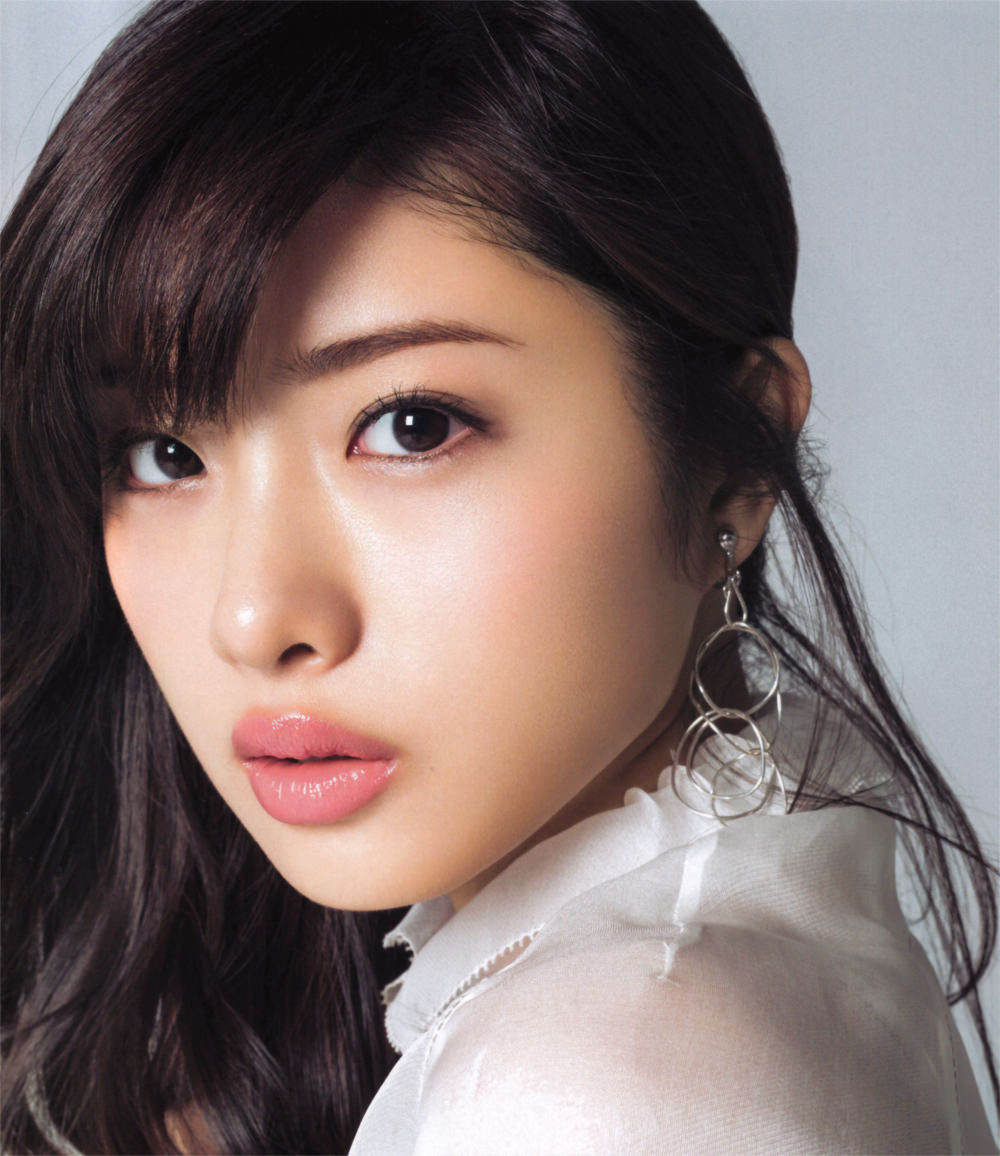

In [60]:
from PIL import Image

img = Image.open("satomi.jpg")
img

In [58]:
!python sample.py --image='satomi.jpg' 

<start> a woman wearing a red shirt and a tie . <end>


In [31]:
from icrawler.builtin import BingImageCrawler
from icrawler.builtin import GoogleImageCrawler

import sys
import os

argv = sys.argv

# 保存ディレクトリが存在していなければ作る
if not os.path.isdir(argv[1]):
  os.makedirs(argv[1])

crawler = BingImageCrawler(storage={"root_dir": argv[1]})
crawler.crawl(keyword="石原さとみ", max_num=5)

2020-10-09 02:36:13,759 - INFO - icrawler.crawler - start crawling...
2020-10-09 02:36:13,760 - INFO - icrawler.crawler - starting 1 feeder threads...
2020-10-09 02:36:13,761 - INFO - feeder - thread feeder-001 exit
2020-10-09 02:36:13,762 - INFO - icrawler.crawler - starting 1 parser threads...
2020-10-09 02:36:13,764 - INFO - icrawler.crawler - starting 1 downloader threads...
2020-10-09 02:36:14,205 - INFO - parser - parsing result page https://www.bing.com/images/async?q=石原さとみ&first=0
2020-10-09 02:36:15,866 - INFO - downloader - image #1	https://www.wacoca.com/wp-content/uploads/2019/03/53729350_213165392974029_9160362611374987438_n.jpg
2020-10-09 02:36:16,543 - INFO - downloader - image #2	http://blog-imgs-79.fc2.com/t/a/k/takarabakovan/isihara7.jpg
2020-10-09 02:36:18,009 - INFO - downloader - image #3	https://dogatch.jp/prod/kanren_news/20200305/32a9ad85c1d13cf3a081b5d795a45884.jpg
2020-10-09 02:36:19,057 - INFO - downloader - image #4	https://hungerfordroad.com/wp-content/uplo

In [62]:
argv[1]

'-f'

In [63]:
from icrawler.builtin import BingImageCrawler
import sys
import os

argv = sys.argv

# 保存ディレクトリが存在していなければ作る
if not os.path.isdir(argv[1]):
  os.makedirs(argv[1])

crawler = BingImageCrawler(storage={"root_dir": argv[1]})
crawler.crawl(keyword="IKKO", max_num=1)

2020-10-09 07:04:20,438 - INFO - icrawler.crawler - start crawling...
2020-10-09 07:04:20,439 - INFO - icrawler.crawler - starting 1 feeder threads...
2020-10-09 07:04:20,440 - INFO - feeder - thread feeder-001 exit
2020-10-09 07:04:20,441 - INFO - icrawler.crawler - starting 1 parser threads...
2020-10-09 07:04:20,443 - INFO - icrawler.crawler - starting 1 downloader threads...
2020-10-09 07:04:20,834 - INFO - parser - parsing result page https://www.bing.com/images/async?q=IKKO&first=0
2020-10-09 07:04:20,869 - INFO - downloader - skip downloading file 000001.jpg
2020-10-09 07:04:20,872 - INFO - downloader - skip downloading file 000002.jpg
2020-10-09 07:04:20,873 - INFO - downloader - skip downloading file 000003.jpg
2020-10-09 07:04:20,874 - INFO - downloader - skip downloading file 000004.jpg
2020-10-09 07:04:20,876 - INFO - downloader - skip downloading file 000005.jpg
2020-10-09 07:04:22,188 - INFO - downloader - downloaded images reach max num, thread downloader-001 is ready to

In [64]:
!wget http://geinou-scandal999.com/wp-content/uploads/2017/04/IKKO3_Fotor.jpg -O "ikko.jpg"

--2020-10-09 07:08:17--  http://geinou-scandal999.com/wp-content/uploads/2017/04/IKKO3_Fotor.jpg
Resolving geinou-scandal999.com (geinou-scandal999.com)... 183.90.240.26
Connecting to geinou-scandal999.com (geinou-scandal999.com)|183.90.240.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681175 (665K) [image/jpeg]
Saving to: ‘ikko.jpg’

ikko.jpg            100%[===================>] 665.21K   735KB/s    in 0.9s    

2020-10-09 07:08:22 (735 KB/s) - ‘ikko.jpg’ saved [681175/681175]



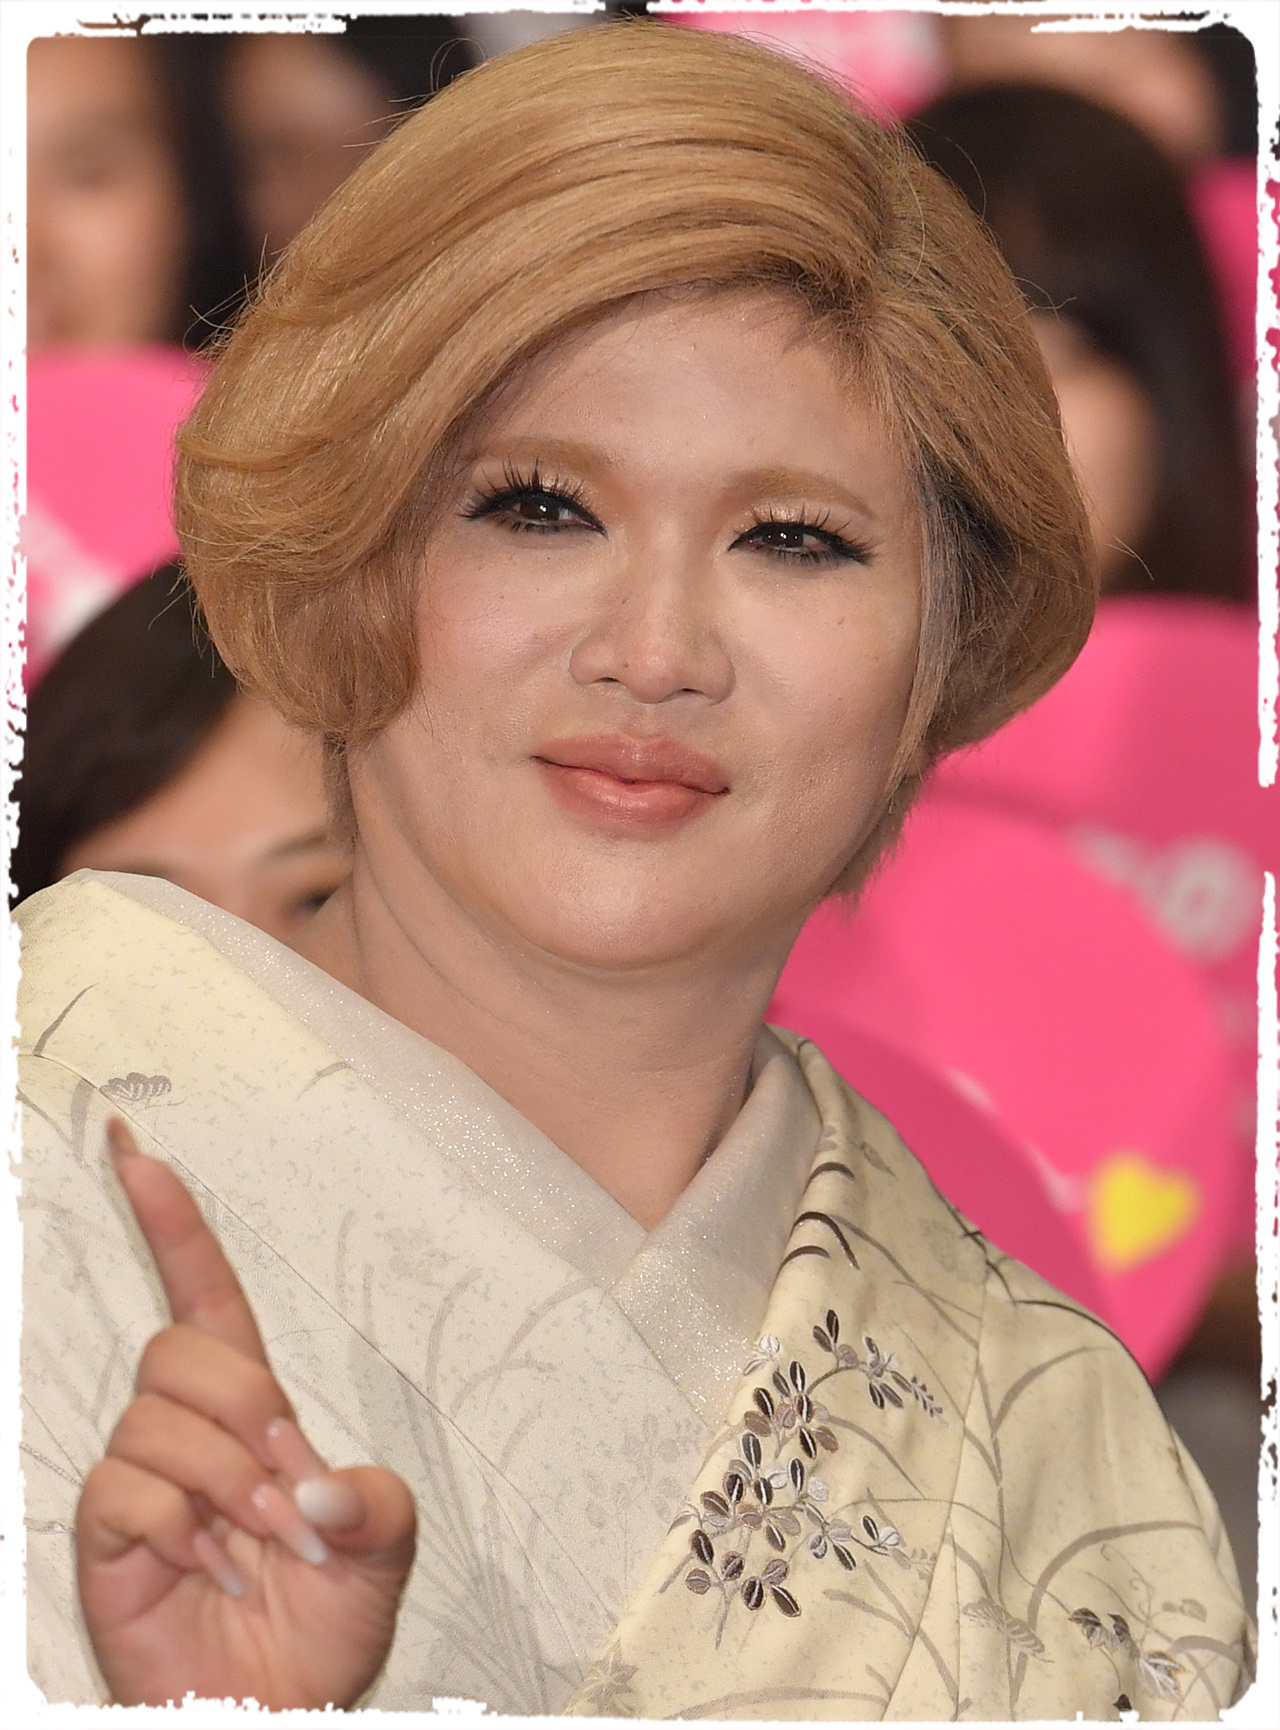

In [68]:
img = Image.open("ikko.jpg")
img

In [65]:
!python sample.py --image='ikko.jpg' 

<start> a woman in a red shirt and a red tie <end>


# 【悲報】IKKOは女性

In [66]:
!wget https://img.redbull.com/images/c_crop,x_603,y_0,h_2133,w_2370/c_fill,w_860,h_782/q_auto,f_auto/redbullcom/2018/07/14/2322c24d-9d57-49f7-affc-dd758fb81a61/hikaru-nakamura-chess -O "chess.jpg"

--2020-10-09 07:20:47--  https://img.redbull.com/images/c_crop,x_603,y_0,h_2133,w_2370/c_fill,w_860,h_782/q_auto,f_auto/redbullcom/2018/07/14/2322c24d-9d57-49f7-affc-dd758fb81a61/hikaru-nakamura-chess
Resolving img.redbull.com (img.redbull.com)... 151.101.2.97, 151.101.66.97, 151.101.130.97, ...
Connecting to img.redbull.com (img.redbull.com)|151.101.2.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62605 (61K) [image/jpeg]
Saving to: ‘chess.jpg’

chess.jpg           100%[===================>]  61.14K  --.-KB/s    in 0.02s   

2020-10-09 07:20:47 (2.49 MB/s) - ‘chess.jpg’ saved [62605/62605]



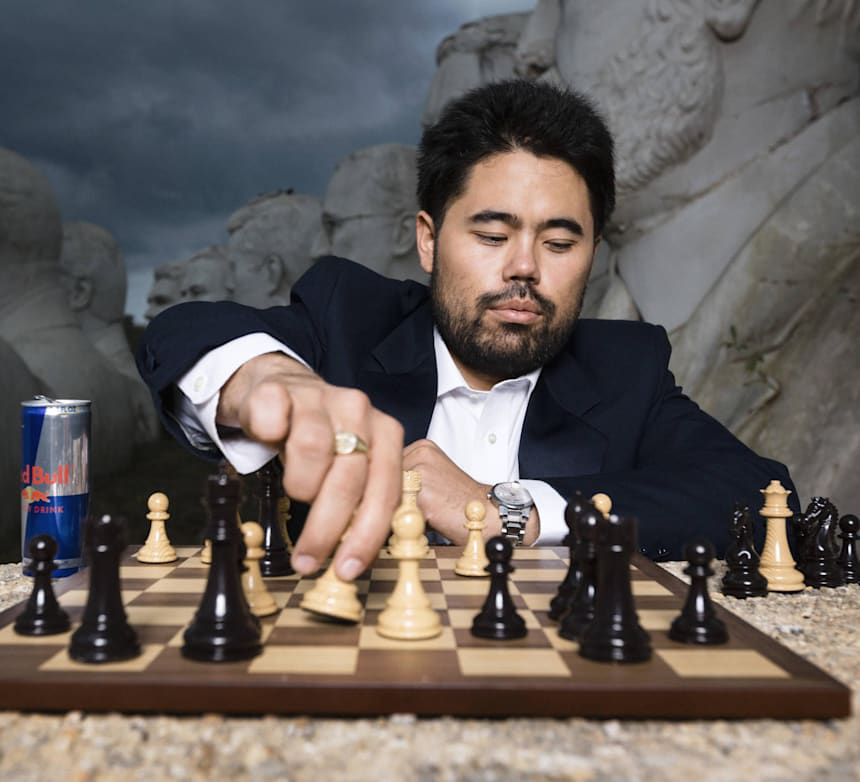

In [69]:
img = Image.open("chess.jpg")
img

In [67]:
!python sample.py --image='chess.jpg' 

<start> a man sitting at a table with a cake and a fork . <end>


### また今度勉強
- [icrawlerソース](https://icrawler.readthedocs.io/en/latest/builtin.html)
- [qiita](https://qiita.com/Yossy_Hal/items/48f43a477d9cdd2af40a)

## 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。


### 回答
[qiita記事](https://qiita.com/lain21/items/9f9f9707ebad4bbc627d)
1. PyTorchで、いい感じのモデルを定義して学習する
2. 学習済みモデルをONNX形式に変換して保存する
3. ONNX形式のモデルをKerasのモデルに変換する
4. Kerasのモデルを、channel_first形式からchannel_last形式に変換する
5. Kerasのモデルをsaved_model.pbとして保存する
6. tflite_convertでその保存されたモデルをTFLiteモデルに変換し、さらに量子化して保存する
7. 変換前と後のモデルの出力を比べる

要約すると、keras用の形式に変換する必要があるということ。

- ONNXについて
> ONNXはOpen Neural Network eXchangeの略で、DeepLearningモデルを様々なフレームワーク間で交換するためのフォーマットです。
これを使えばあるDeepLearningフレームワークで学習させたモデルを他のフレームワークでも利用することができます。DeepLearningフレームワーク戦国時代には嬉しい仕組みです。
ちなみにONNXは「オニキス」と発音します。

pytorchとtensorflow間で統一させるフォーマットがある。

- コードについて
pytorch -> onnx -> keras -> tflite

pytorch.load => onnx形式にエクスポート。onnxライブラリあり。 => onnx_to_kerasメソッドでkeras形式に変換 => keras.get_weightsでloadする



[その他参考ページ：【後編】「Keras」と「PyTorch」を徹底比較してみた！～データローダ・転移学習編～](https://rightcode.co.jp/blog/information-technology/machine-learning-frameworks-keras-pytorch-comparison-data-loader-transfer-learning)



## 【問題4】（アドバンス課題）コードリーディングと書き換え
モデル部分はmodel.pyに書かれていますが、Kerasではこのモデルがどのように記述できるかを考え、コーディングしてください。その際機械翻訳のサンプルコードが参考になります。



### 回答なし

## 【問題5】（アドバンス課題）発展的調査
《他の言語の翻訳を行う場合は？》


問題1の実装を使い日本語と英語の翻訳を行いたい場合はどのような手順を踏むか考えてみましょう。


《機械翻訳の発展的手法にはどのようなものがある？》


機械翻訳のための発展的手法にはどういったものがあるか調査してみましょう。


《文章から画像生成するには？》


イメージキャプショニングとは逆に文章から画像を生成する手法もあります。どういったものがあるか調査してみましょう。

### 回答なし